##**Image Colorization** 

Task: To convert a grayscale image into color image using  deep learning approach.

This code is inspired by [DigitalSreeni- Autoencoder using transfer learning](https://www.youtube.com/watch?v=bIaT2X5Hd5k)

Modification:

*   Own dataset
*   Shuffle the image data for model training to avoid bias and overfitting
*   Regularization
*   Parameter tuning
*   Early stopping


# **1. Mount the Google Colab with Google Drive by sign in to your e-mail account.**

In [ ]:
# Mount to Google drive
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


# **2. Change directory to designated image dataset repository.**

*  %cd - change directory 
*  %pwd - to check current directory location

In [ ]:
# Change directory
%cd gdrive
%cd My Drive
%cd Colorization
%pwd

# **3. Import all the required libraries and its functions**


*   Tensorflow
*   Keras
*   Numpy
*   Scikit Image
*   Miscellaneous operating system interfaces (OS)

In [ ]:
# Import libraries
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import keras
import os
from tensorflow.keras.regularizers import l2
from keras.applications.vgg16 import VGG16

# **4. Apply ImageDataGenerator function for image normalization.**

Rescale by 255 as the image RGB value has range of 0 to 255.

In [ ]:
# Construct image dataset and normaliztion
train_datagen = ImageDataGenerator(rescale=1. / 255)

# **5. Load the image dataset from the path and resize all the loaded image and compile them into image batch.**

*   Image Size : 224 x 224
*   Batch Size : 30


Note: Larger image size and batch size may require more processing power during model training. Also, it might takes longer time as well. However, larger image size and batch size may carry more information for model training.

In [ ]:
# Load and resize image data
path = './data/train/'
train = train_datagen.flow_from_directory(path, target_size=(224, 224),
                                          batch_size=30, 
                                          shuffle=True, 
                                          class_mode=None)

Found 1347 images belonging to 1 classes.


# **6. Convert RGB values into LAB color space value.**



*   L - lightness
*   A - Red/Green Values
*   B - Blue/Yellow Values

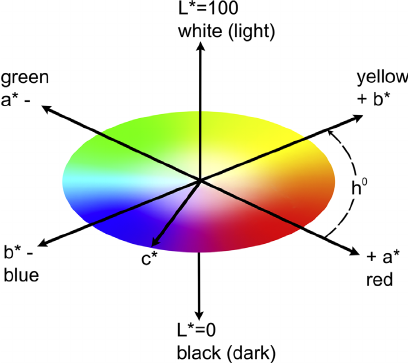

A and B values are in range of -127 to 128, thus, devide by 128 to constrain the values between -1 to 1.

Moreover, image vaues are sperate in to X and Y array.

X represent the grayscale image which consist of only L values, while Y array consists of A and B values. We are going to feed the model with X, Y values will be the labels.

In [ ]:
# Convert the RGB channels into LAB channels
# Split the training features(X) and labels (Y)
X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0])
      Y.append(lab[:,:,1:] / 128) 
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) # Dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

(30, 224, 224, 1)
(30, 224, 224, 2)


# **7. VGG16 network strucure**

VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”.

The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.

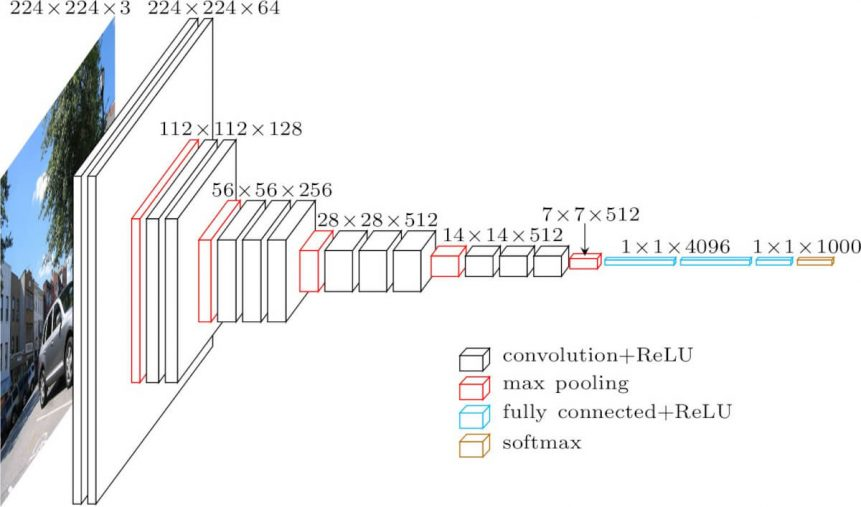

However, we are not going to perform features extraction for the 1000 classes, only the encoded features weights will be extracted.


Load the VGG16 network and its trained parameters.  Newmodel is constructed by the VGG16 network structure.

Note: layer.trainable will be set to be "False" as we are not going to train it.

In [ ]:
# Load VGG16 network and extract the model until layer 19 only
vggmodel = VGG16()
newmodel = Sequential()
# num = 0
for i, layer in enumerate(vggmodel.layers):
    if i < 19:  # Only up to 19th layer to include feature extraction only
        newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
    layer.trainable = False  # We don't want to train these layers again, so False.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

# **8. VGG16 features will be constructed in order to encode the image using trained weights from VGG16 network.**

In [ ]:
# Features extraction from the VGG16 network
vggfeatures = []
for i, sample in enumerate(X):
    sample = gray2rgb(sample)
    sample = sample.reshape((1, 224, 224, 3))
    prediction = newmodel.predict(sample)
    prediction = prediction.reshape((7, 7, 512))
    vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

# **9. Construct encoder network**

4 times up sampling to allow the model generate A B values that natch input image size.

Two kernel regularizer l2 added to avoid bias and overfitting.

"tanh" activation function is needed to generate output with range of -1 to 1 with only 2 neurals that return 2 values that represent A and B channels.

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(7, 7, 512)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7, 7, 256)         1179904   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         295040    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 56, 56, 32)       

# **10. Model Training**

Training set to run for 10000 epoches and 60 images for training per batch. X is serve as input and Y is the prediction output.

Callbacks params is used for early stopping.

Lastly, model save at the written path and its ready for prediction and image colorization.

In [ ]:
# Model training
model.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode ='max' , patience=300)
model.fit(vggfeatures, Y, verbose=1, epochs=10000, batch_size=60)#, callbacks=[callback])

model.save('model/colorize_autoencoder_VGG16.model')

# **11. Load the model from the given directory and file name.**

In [ ]:
 # Load the trained model
model = tf.keras.models.load_model(
    'model/colorize_autoencoder_VGG16.model',
    custom_objects=None,
    compile=True)
# print out model, to check if the model loaded propoerly
model

# **12. Model Testing**

Finally, load the testing dataset from path. Then, resize and convert the image into grayscale and give image size (224 x 224).

Additionally, VGG16 network structure and decoder network will be used for prediction consecutively.

The network is shown as the figure below.

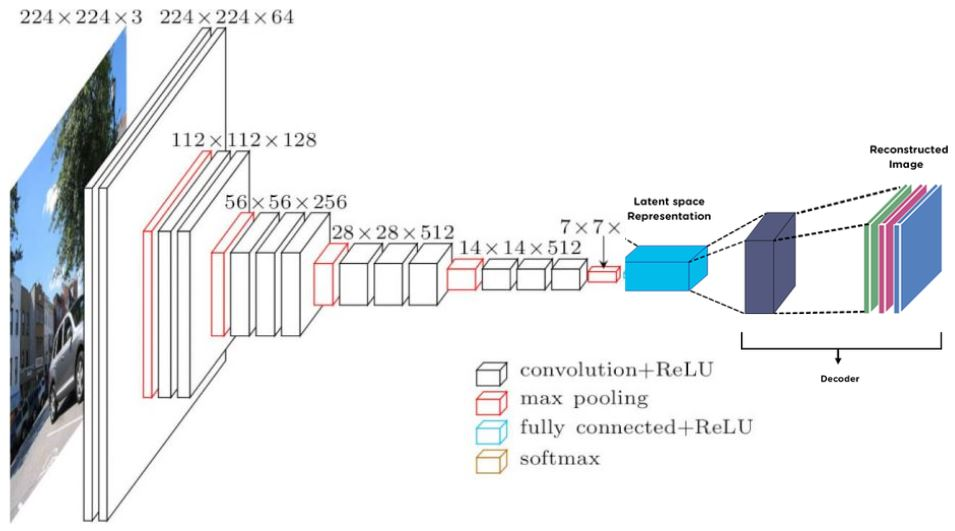

In [ ]:
# Model testing

# Load testing images
path = './testing/'
files = os.listdir(path)
for idx, file in enumerate(files):
    test = img_to_array(load_img(path + file))
    test = resize(test, (224, 224), anti_aliasing=True)
    test *= 1.0 / 255
    # Convert RGB to LAB
    lab = rgb2lab(test)
    l = lab[:, :, 0] 
    L = gray2rgb(l)
    # Reshape the match the input shape of VGG16
    L = L.reshape((1, 224, 224, 3))
    # Model prediction
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)
    # de-normalize
    ab = ab * 128
    cur = np.zeros((224, 224, 3))
    # Map the image with LAB channel values respectively
    cur[:, :, 0] = l
    cur[:, :, 1:] = ab
    imsave('results_vgg_sunset/result_vgg_sunset' + str(idx) + ".jpg", lab2rgb(cur))
print("Completed!")